# เตรียมดึงฝนรายชั่วโมงเพื่อนำมาหาค่า MFB นำไปปรับแก้เรดาร์แต่ละสถานี
* อย่าดึงบ่อย ครั้งเดียวพอ

In [1]:
'''
2024.09.22
โค้ดนี้พัฒนาโดย รองศาสตราจารย์ ดร. นัฐพล มหาวิค ภาควิชาทรัพยากรธรรมชาติและสิ่งแวดล้อม คณะเกษตรศาสตร์ฯ มหาวิทยาลัยนเรศวร 
ในงานวิจัย เรื่อง "การวิจัยและพัฒนาผลิตภัณฑ์โมเสคฝนประมาณค่าจากเรดาร์ตรวจอากาศในพื้นที่ระดับลุ่มน้ำของประเทศไทยด้วยเทคโนโลยีภูมิสารสนเทศรหัสเปิด"
สนับสนุนทุนวิจัยโดยสํานักงานการวิจัยแห่งชาติ (วช.)  แผนงานการวิจัยและนวัตกรรมแผนงานด้านการบริหารจัดการภัยพิบัติทางธรรมชาติ 
ประจำปีงบประมาณ 2566  ตามสัญญา เลขที่ N25A660467 ผู้นำโค้ดนี้ไปใช้หรือดัดแปลงควรอ้างอิงงานวิจัยชิ้นนี้ตามหลักเกณฑ์การอ้างอิงสากล
เรียนหลักการเรดาร์และภูมิสารสนเทศ ที่ https://www.youtube.com/@Nattapon_Mahavik/playlists
หนังสือเรดาร์ตรวจอากาศทางอุตุนิยมวิทยา สำนักพิมพ์จุฬาฯ : https://www.chulabook.com/education/144567
หนังสือออนไลน์เรดาร์ตรวจอากาศทางอุตุนิยมวิทยา สำนักพิมพ์จุฬาฯ : https://www.chulabook.com/education/205129
ติดต่อ nattaponm@nu.ac.th
'''

import os
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil import rrule
from pathlib import Path
import glob

# Constants
URL_SOURCE = 'https://tiservice.hii.or.th/opendata/data_catalog/hourly_rain/'
STATION_METADATA_URL = 'https://tiservice.hii.or.th/opendata/data_catalog/daily_rain/0station_metadata.csv'
GAUGE_BUFFER_DIR = './0Zprocessing_data/0guage_in_buffer240km'
OUTPUT_DIR = './0Zprocessing_data/0hourly_rain_each_radar'

def get_rainfall_hii(df_filter, start_date, end_date, radar_name):
    """
    Download rainfall data from HII for specified stations and date range.
    """
    date_start = datetime.strptime(start_date, '%Y-%m-%d')
    date_end = datetime.strptime(end_date, '%Y-%m-%d')
    
    radar_output_dir = os.path.join(OUTPUT_DIR, radar_name)
    
    for date in rrule.rrule(rrule.MONTHLY, dtstart=date_start, until=date_end):
        year, month = date.strftime('%Y'), date.strftime('%m')
        path = os.path.join(radar_output_dir, year, month)
        Path(path).mkdir(parents=True, exist_ok=True)
        
        for code in df_filter['code']:
            url = f"{URL_SOURCE}{year}/{year}{month}/{code.strip()}.csv"
            result = requests.get(url)
            if result.status_code == 200:
                file_path = Path(os.path.join(path, f"{code.strip()}.csv"))
                file_path.write_bytes(result.content)
                print(f"Downloaded: {year}/{month}/{code.strip()} for {radar_name}")
            else:
                print(f"Failed: {year}/{month}/{code.strip()} for {radar_name}")

def process_rainfall_data(start_date, end_date, radar_name):
    """
    Process downloaded rainfall data and create hourly CSV files.
    """
    date_start = datetime.strptime(start_date, '%Y-%m-%d')
    date_end = datetime.strptime(end_date, '%Y-%m-%d')
    
    radar_output_dir = os.path.join(OUTPUT_DIR, radar_name)
    prec = []
    
    for date in rrule.rrule(rrule.MONTHLY, dtstart=date_start, until=date_end):
        year, month = date.strftime('%Y'), date.strftime('%m')
        target = os.path.join(radar_output_dir, year, month)
        
        for filename in os.listdir(target):
            station = filename.split('.')[0]
            df = pd.read_csv(os.path.join(target, filename))
            df['station'] = station
            prec.append(df)
    
    prec_pd = pd.concat(prec).reset_index(drop=True)
    rain_subset = prec_pd[['date', 'time', 'rain', 'station']]
    rain_subset['full_date'] = rain_subset['date'] + '-' + rain_subset['time']
    
    return rain_subset

def export_hourly_rainfall(rain_subset, df_filter, start_date, end_date, radar_name):
    """
    Export processed rainfall data as hourly CSV files.
    """
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    date_range = [start + timedelta(days=x) for x in range((end - start).days + 1)]
    
    out_rain_hr_path = os.path.join(OUTPUT_DIR, radar_name, 'hourly')
    Path(out_rain_hr_path).mkdir(parents=True, exist_ok=True)
    
    for date in date_range:
        for hour in rain_subset['time'].unique():
            dt = datetime.strptime(f"{date.strftime('%Y-%m-%d')}-{hour}", '%Y-%m-%d-%H:%M')
            print(f"Processing: {dt} for {radar_name}")
            
            rain_ = rain_subset[rain_subset['full_date'] == dt.strftime('%Y-%m-%d-%H:%M')]
            df_rain_pl = rain_.merge(df_filter, left_on='station', right_on='code')
            
            # Quality control
            df_ = df_rain_pl[~df_rain_pl['rain'].isin(['-', -999.0])].dropna().reset_index(drop=True)
            
            # Export hourly rainfall CSV
            file_hr = dt.strftime('%Y%m%d%H') + '.csv'
            df_.to_csv(os.path.join(out_rain_hr_path, file_hr), encoding='utf-8-sig', index=False)

def process_radar_buffer_gauges(start_date, end_date):
    """
    Process gauges for each radar buffer and download corresponding rainfall data.
    """
    # Read HII station metadata
    df_hii = pd.read_csv(STATION_METADATA_URL)
    df_hii['code'] = df_hii['station_code'].str.strip()

    # Process each radar buffer CSV
    for csv_file in glob.glob(os.path.join(GAUGE_BUFFER_DIR, '*_gauges.csv')):
        radar_name = os.path.basename(csv_file).split('_')[1]
        print(f"Processing radar: {radar_name}")

        # Read gauge data for the current radar
        df_gauge = pd.read_csv(csv_file)
        
        # Filter HII stations based on gauges in the current radar buffer
        df_filter = df_hii[df_hii['code'].isin(df_gauge['code'].str.strip())]
        
        # Download rainfall data for the filtered stations
        get_rainfall_hii(df_filter, start_date, end_date, radar_name)
        
        # Process and export hourly rainfall data
        rain_subset = process_rainfall_data(start_date, end_date, radar_name)
        export_hourly_rainfall(rain_subset, df_filter, start_date, end_date, radar_name)

def main():
    # Set date range
    start_date = '2018-07-15'
    end_date = '2018-07-25'
    
    # Process gauges for each radar buffer and download data
    process_radar_buffer_gauges(start_date, end_date)

if __name__ == "__main__":
    main()

Processing radar: CHN
Failed: 2018/07/ATG011 for CHN
Failed: 2018/07/ATG021 for CHN
Failed: 2018/07/ATG031 for CHN
Failed: 2018/07/ATG032 for CHN
Failed: 2018/07/ATG042 for CHN
Failed: 2018/07/ATG051 for CHN
Failed: 2018/07/ATG052 for CHN
Failed: 2018/07/ATG072 for CHN
Failed: 2018/07/ATG081 for CHN
Failed: 2018/07/ATG082 for CHN
Failed: 2018/07/ATG091 for CHN
Failed: 2018/07/ATG092 for CHN
Failed: 2018/07/ATG101 for CHN
Failed: 2018/07/ATG111 for CHN
Failed: 2018/07/ATG112 for CHN
Failed: 2018/07/ATG121 for CHN
Failed: 2018/07/ATG122 for CHN
Failed: 2018/07/ATG131 for CHN
Failed: 2018/07/ATG132 for CHN
Failed: 2018/07/ATG141 for CHN
Failed: 2018/07/ATG142 for CHN
Failed: 2018/07/ATG151 for CHN
Failed: 2018/07/ATG152 for CHN
Failed: 2018/07/ATG161 for CHN
Failed: 2018/07/ATG162 for CHN
Failed: 2018/07/ATG171 for CHN
Failed: 2018/07/ATG181 for CHN
Failed: 2018/07/ATG182 for CHN
Downloaded: 2018/07/BARI for CHN
Downloaded: 2018/07/BDLH for CHN
Downloaded: 2018/07/BHUN for CHN
Downloaded:

## พลอตแผนที่ฝนรายชั่วโมงตัวอย่าง

C:\Users\Admin\AppData\Local\Temp\ipykernel_32728\835317971.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


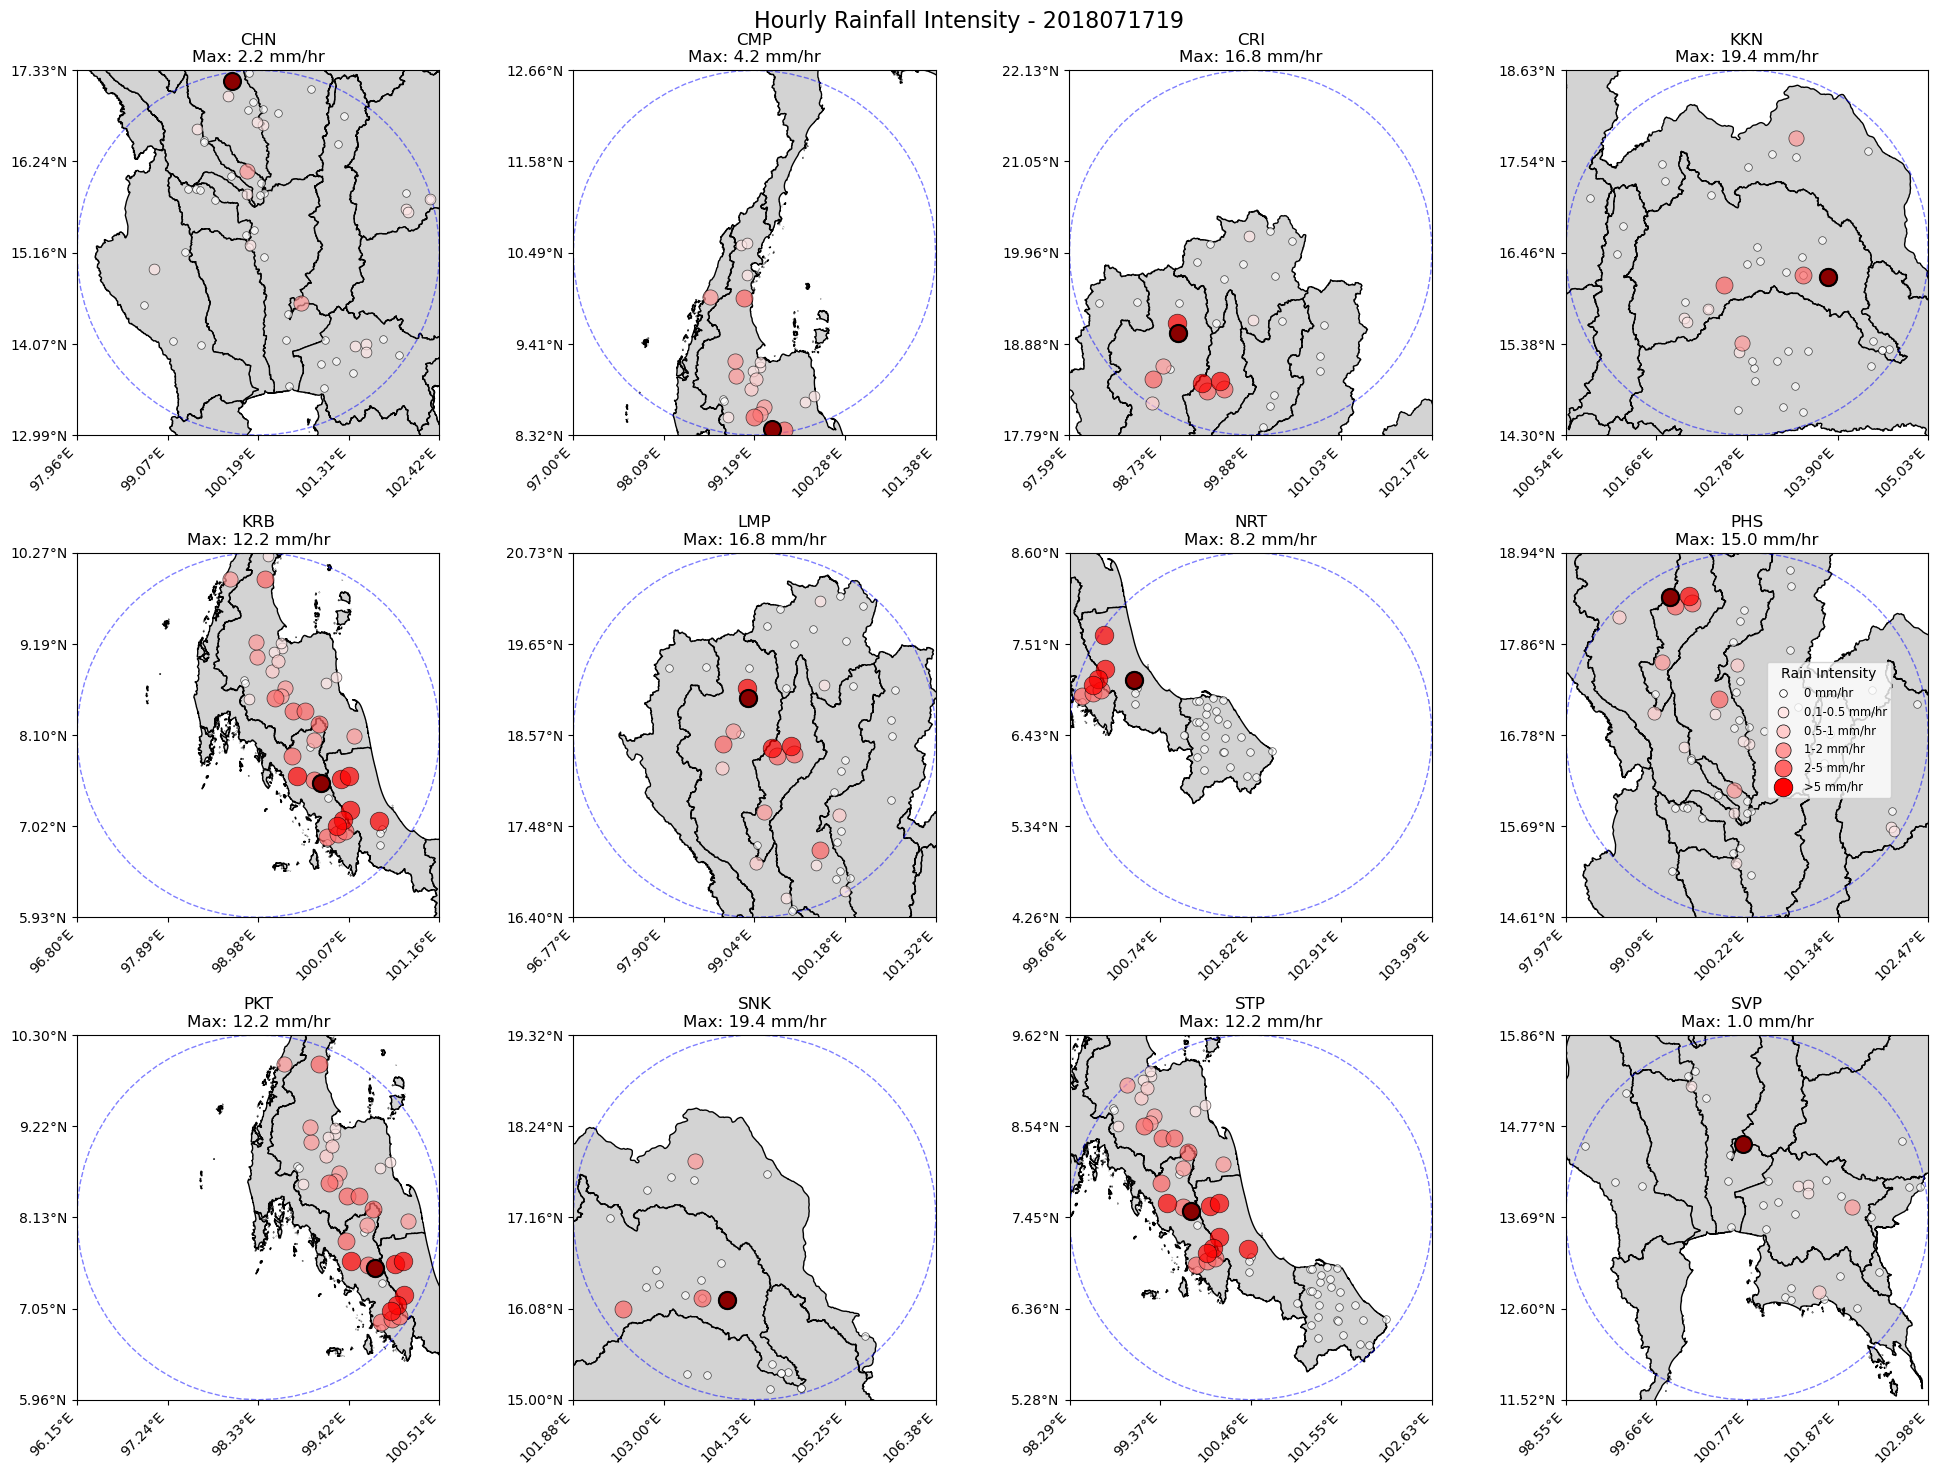

Map saved as ./0Zprocessing_data/0map\rainfall_map_2018071719.png


In [6]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Constants
GAUGE_BUFFER_DIR = './0Zprocessing_data/0guage_in_buffer240km'
HOURLY_RAIN_DIR = './0Zprocessing_data/0hourly_rain_each_radar'
OUTPUT_MAP_DIR = './0Zprocessing_data/0map'
BASIN_SHAPEFILE = '../1data/1GIS/0base_map_gis/MainBasin_ONWR_Law_WGS84Geo.shp'
BUFFER_SHAPEFILE_DIR = './0Zprocessing_data/0shape_buffers'

def read_gauge_data(radar_name):
    """Read gauge data for a specific radar."""
    gauge_file = os.path.join(GAUGE_BUFFER_DIR, f"stations_{radar_name}_240km_gauges.csv")
    return pd.read_csv(gauge_file)

def read_rainfall_data(radar_name, timestamp):
    """Read hourly rainfall data for a specific radar and timestamp."""
    rain_file = os.path.join(HOURLY_RAIN_DIR, radar_name, 'hourly', f"{timestamp}.csv")
    return pd.read_csv(rain_file)

def read_buffer_shapefile(radar_name):
    """Read buffer shapefile for a specific radar."""
    buffer_file = os.path.join(BUFFER_SHAPEFILE_DIR, f"stations_{radar_name}_240km.shp")
    return gpd.read_file(buffer_file)

def plot_rainfall(ax, basin, rain_data, gauge_data, radar_name, buffer_gdf):
    """Plot rainfall data for a single radar station."""
    # Merge rainfall data with gauge locations
    merged_data = pd.merge(rain_data, gauge_data, left_on='station', right_on='code')
    
    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        merged_data, 
        geometry=gpd.points_from_xy(merged_data.longitude, merged_data.latitude),
        crs="EPSG:4326"
    )

    # Plot basin
    basin.plot(ax=ax, color='lightgrey', edgecolor='black')

    # Plot buffer
    buffer_gdf.plot(ax=ax, color='none', edgecolor='blue', linestyle='--', alpha=0.5)

    # Define rain intensity classes
    rain_classes = [0, 0.1, 0.5, 1, 2, 5, np.inf]
    colors = ['#FFFFFF', '#FFE6E6', '#FFCCCC', '#FF9999', '#FF6666', '#FF0000']
    labels = ['0', '0.1-0.5', '0.5-1', '1-2', '2-5', '>5']

    # Plot rainfall stations
    for i, (lower, upper) in enumerate(zip(rain_classes[:-1], rain_classes[1:])):
        mask = (gdf['rain'] >= lower) & (gdf['rain'] < upper)
        ax.scatter(gdf.loc[mask, 'longitude'], gdf.loc[mask, 'latitude'], 
                   c=colors[i], s=(i+1)*30, alpha=0.7, edgecolor='black', linewidth=0.5)

    # Highlight max rainfall station
    max_rain_station = gdf.loc[gdf['rain'].idxmax()]
    ax.scatter(max_rain_station['longitude'], max_rain_station['latitude'], 
               c='darkred', s=150, alpha=1, edgecolor='black', linewidth=1.5)

    # Set plot limits based on buffer extent
    bounds = buffer_gdf.total_bounds
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])

    # Add lat/long ticks
    ax.set_xticks(np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 5))
    ax.set_yticks(np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 5))
    ax.set_xticklabels([f"{x:.2f}°E" for x in ax.get_xticks()], rotation=45, ha='right')
    ax.set_yticklabels([f"{y:.2f}°N" for y in ax.get_yticks()])

    ax.set_title(f"{radar_name}\nMax: {max_rain_station['rain']:.1f} mm/hr")

def create_rainfall_map(timestamp):
    """Create a 4x3 grid of rainfall maps for all radar stations."""
    # Read basin shapefile
    basin = gpd.read_file(BASIN_SHAPEFILE)

    # Get list of radar stations
    radar_stations = [f.split('_')[1] for f in os.listdir(GAUGE_BUFFER_DIR) if f.endswith('_gauges.csv')]

    # Create 4x3 subplot
    fig, axs = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle(f"Hourly Rainfall Intensity - {timestamp}", fontsize=16)

    for idx, radar in enumerate(radar_stations):
        row = idx // 4
        col = idx % 4
        gauge_data = read_gauge_data(radar)
        rain_data = read_rainfall_data(radar, timestamp)
        buffer_gdf = read_buffer_shapefile(radar)
        plot_rainfall(axs[row, col], basin, rain_data, gauge_data, radar, buffer_gdf)

    # Add legend
    legend_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
    legend_ax.axis('off')
    rain_classes = [0, 0.1, 0.5, 1, 2, 5, np.inf]
    colors = ['#FFFFFF', '#FFE6E6', '#FFCCCC', '#FF9999', '#FF6666', '#FF0000']
    labels = ['0', '0.1-0.5', '0.5-1', '1-2', '2-5', '>5']
    for i, (label, color) in enumerate(zip(labels, colors)):
        legend_ax.scatter([], [], c=color, s=(i+1)*30, label=f'{label} mm/hr', edgecolor='black', linewidth=0.5)
    legend_ax.legend(title='Rain Intensity', loc='center', fontsize='small')

    plt.tight_layout()
    
    # Save the figure
    output_file = os.path.join(OUTPUT_MAP_DIR, f"rainfall_map_{timestamp}.png")
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Map saved as {output_file}")

def main():
    # Ensure output directory exists
    Path(OUTPUT_MAP_DIR).mkdir(parents=True, exist_ok=True)

    # Specify the timestamp for which you want to create the map
    timestamp = "2018071719"  # Change this to the desired timestamp

    create_rainfall_map(timestamp)

if __name__ == "__main__":
    main()